<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

***

## First Level Analysis - **Default** Hemodynamic Response Function

The present jupyter notebook contains the code to reproduce the first level analysis with nilearn's default hemodynamic response functions (HRF): spm or glover without derivates. The function has to be selected before running the analysis.

Follow the code step-wise. 


In [1]:
# ---  Imports --- 
import os
import glob
import nilearn
import numpy as np 
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from numpy import savetxt
from nilearn import plotting, image, masking
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

**Select the hemodynamic response function!** 

In [10]:
# --- Select HRF model ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    glover
    spm
"""
#hrf_function = 'glover'
hrf_function = 'spm'
print('The chosen HRF model is:', hrf_function)

The chosen HRF model is: spm


**Next step: define input and output directories.**

In [11]:
# --- Init variables --- 
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
            
# --- Data path ---
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

# --- Output directories ---
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
subdirectories = ['glover', 'spm']

base_dir = os.path.join(output_dir, 'glover') if hrf_function == 'glover' else os.path.join(output_dir, 'spm')
matrix_dir = os.path.join(base_dir, 'matrix/')
image_dir = os.path.join(base_dir, 'image/')
model_dir = os.path.join(base_dir, 'model/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
residuals_dir = os.path.join(base_dir, 'residuals/')
effect_var_dir = os.path.join(base_dir, 'effect_var/')
predic_timeseries_dir = os.path.join(base_dir, 'predicted_timeseries/')
z_score_dir = os.path.join(base_dir, 'z_score/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['matrix', 'image', 'model', 'beta_estimates', 'residuals', 'effect_var', 'predicted_timeseries', 'z_score']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
                    
            

### Let's analyse!

1. Import the metadata file, whith the subject number, TR, timings, and other parameters are required for the analysis.
2. Define variables.
3. Compute the even regressors, basically the stimulation protocol.
4. Compute the motion regressors, output by RABIES preprocess pipeline in the cofounders.
5. Compute the design matrix and the first level model
6. Compute the contrast and plot the statistical maps
7. Save ouputs in specific directories

The chosen HRF model is: spm
index: 10
subj: 200200
ses: 1
TR: 1.5
n stim: 6
stim duration: 6
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


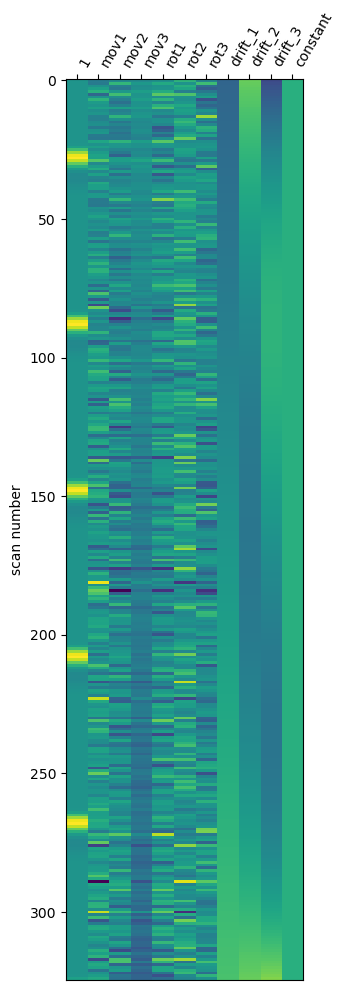

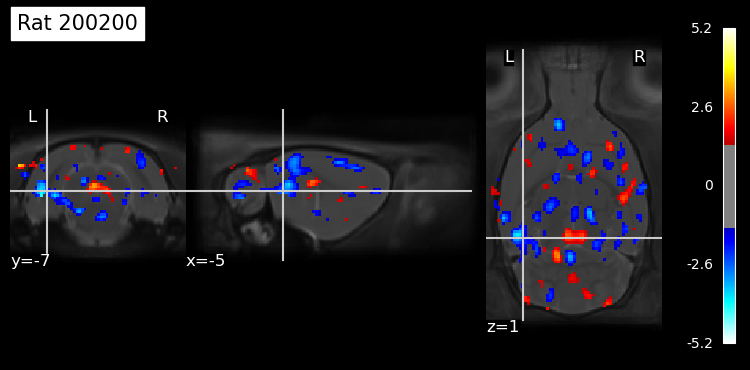

In [12]:
# ---------- FIRST LEVEL ANALYSIS ------------
# --------------- Default HRF ----------------

print('The chosen HRF model is:', hrf_function)

for index in range(10, 11):
    
    # --- Define variables --- 
    
    subj_num=str(df.iloc[index]['rat.sub'])   #[:-2]
    ses=str(df.iloc[index]['rat.ses'])
    print('index:', index)
    print('subj:', subj_num)
    print('ses:', ses)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-{}/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, ses))[0]
    func_img = nib.load(subject_path) 
    
    tr = int(df.iloc[index]['func.TR'])
    #tr = 1.5
    n_scans = func_img.shape[3]   
    frame_times = np.arange(n_scans) * tr 
    
  # --- Events regressors ---     
    
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))              #count number of stimulation, number of onset
    duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
       
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]                    # Get onsets from metadata file
    onsets = onset_metadata 
      
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration_1_stim)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-{}_run-1_bold_RAS_combined_confounds.csv'.format(subj_num, ses)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-{}/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, ses))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Design matrix and first-level model --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_function,
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               smoothing_fwhm=0.45,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
        
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 1.4, 
                                       title = 'Rat {}'.format(subj_num))
        
    
    #-- Save outputs --  
    savetxt(matrix_dir+'matrix_sub-0{}_ses-{}.csv'.format(subj_num, ses), design_matrix, delimiter=',')
    nib.save(residuals, residuals_dir+'residuals_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))         #save this to nifti
    #nib.save(predicted_timeseries, predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
    nib.save(statistical_map['z_score'], z_score_dir+'z_score_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))           #save z map
    nib.save(statistical_map['effect_size'], beta_dir+'beta_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))             #save the betaestimates
    nib.save(statistical_map['effect_variance'], effect_var_dir+'effect_var_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))  #save the betaestimates
    plt.savefig(image_dir+'stat_map_sub-0{}_ses-{}.png'.format(subj_num, ses))


In [40]:
print('TR:', tr)
print('stim duration:', duration_1_stim)
    
print('n_scans', n_scans)
print('onsets', onsets)
print('frame_times', frame_times) 
print('events', events)

TR: 1
stim duration: 7
n_scans 221
onsets [ 24  44  64  84 104 124 144 164 184 204]
frame_times [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220]
events

**Save the modeled BOLD response**

First, extract the model from the first column of the design matrix. Plot it to check if it makes sense. 

We saved the model once per dataset, as stimulation protocols are similar across scans within each datasets.

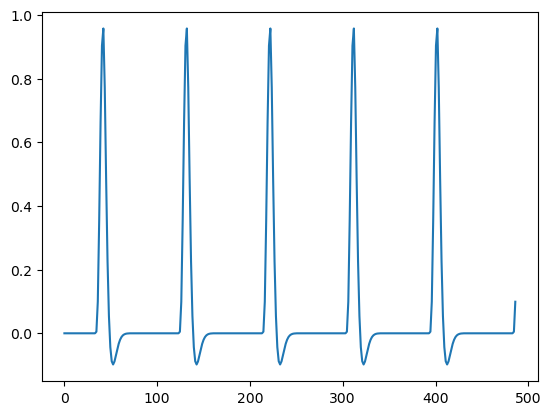

In [13]:
# --- Save model ---
model = design_matrix.iloc[:, 0]
plt.plot(model)

#savetxt(model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')

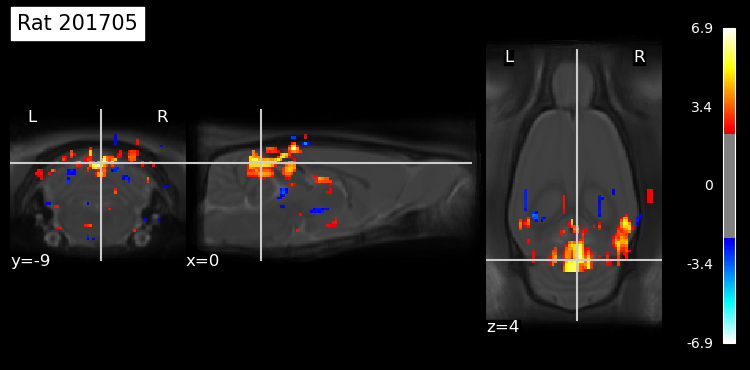

In [68]:
# --- Plot statistical map ---

colorbar = plot_stat._cbar                      # get the statistical scale from the plot
vmin, vmax = colorbar.mappable.get_clim()
set_tresh = vmax / 3                            # Set the threshold to 1/3 of the max value of the colorbar

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = set_tresh, 
                                       title = 'Rat {}'.format(subj_num))
    

### Test on 020016-17

The chosen HRF model is: spm
index: 156
subj: 201704
ses: 2
TR: 1
n stim: 20
stim duration: 6
Contrasts:  [1. 0. 0. 0. 0.]
index: 157
subj: 201705
ses: 2
TR: 1
n stim: 20
stim duration: 6
Contrasts:  [1. 0. 0. 0. 0.]
index: 158
subj: 201706
ses: 2


AttributeError: 'float' object has no attribute 'split'

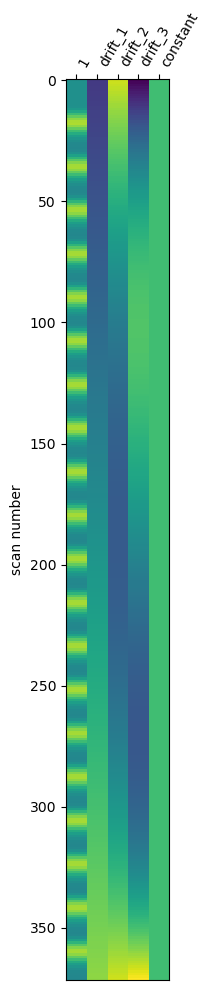

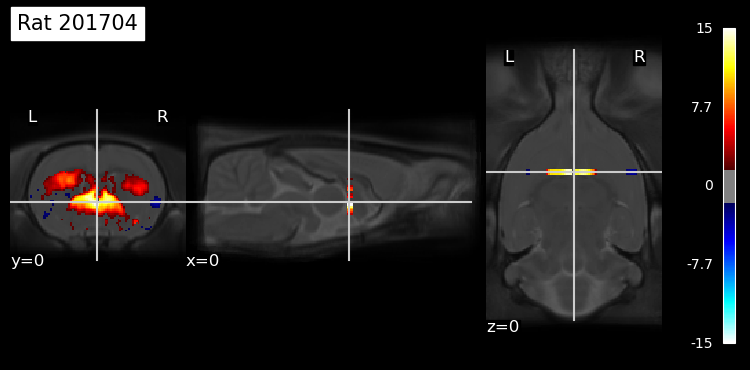

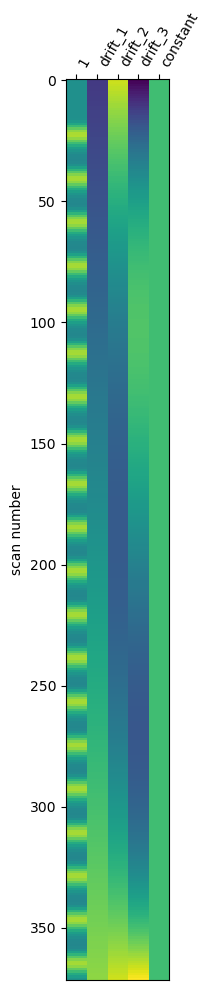

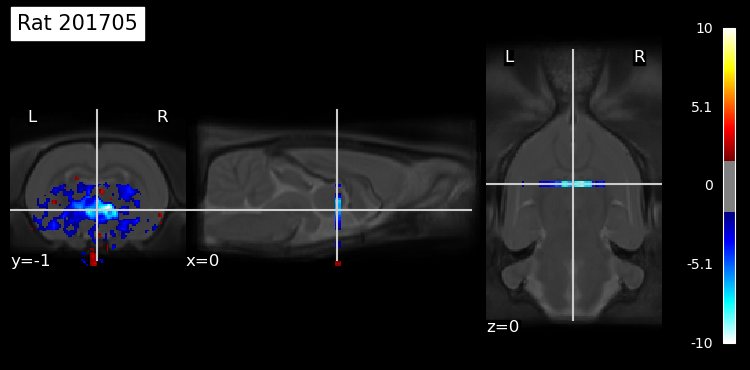

In [4]:
# ---------- FIRST LEVEL ANALYSIS ------------
# --------------- Default HRF ----------------

print('The chosen HRF model is:', hrf_function)
analysis_folder = "/project/4180000.19/multirat_stim/rabies/BIDS_input/"

for index in range(156, 157):
    
    # --- Define variables --- 
    
    subj_num=str(df.iloc[index]['rat.sub'])   #[:-2]
    ses=str(df.iloc[index]['rat.ses'])
    print('index:', index)
    print('subj:', subj_num)
    print('ses:', ses)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}/ses-1/func/*.nii.gz".format(subj_num, ses, ses))[0]
    func_img = nib.load(subject_path) 
    
    tr = int(df.iloc[index]['func.TR']) 
    n_scans = func_img.shape[3]   
   
    frame_times = np.arange(n_scans) * tr 
    
    # --- Events regressors ---     
    
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))              #count number of stimulation, number of onset
    duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
       
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]                    # Get onsets from metadata file
    onsets = onset_metadata  
    
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration_1_stim)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-{}_run-1_bold_RAS_combined_confounds.csv'.format(subj_num, ses)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-{}/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, ses))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Design matrix and first-level model --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_function,
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               smoothing_fwhm=0.45,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
        
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 1.7, 
                                       title = 'Rat {}'.format(subj_num))
        
    
    #-- Save outputs --  
    savetxt('/project/4180000.19/multirat_stim/scratch/rabies_test/analysis_16-17_bf-Rabies/first_level/matrix/matrix_sub-0{}_ses-{}.csv'.format(subj_num, ses), design_matrix, delimiter=',')
    nib.save(residuals, '/project/4180000.19/multirat_stim/scratch/rabies_test/analysis_16-17_bf-Rabies/first_level/residuals/residuals_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))         #save this to nifti
    nib.save(statistical_map['z_score'], '/project/4180000.19/multirat_stim/scratch/rabies_test/analysis_16-17_bf-Rabies/first_level/z_score/z_score_sub-0{}_ses-{}.nii.gz'.format(subj_num, ses))           #save z map
    plt.savefig("/project/4180000.19/multirat_stim/scratch/rabies_test/analysis_16-17_bf-Rabies/first_level/image/stat_map_sub-0{}_ses-{}.png".format(subj_num, ses))


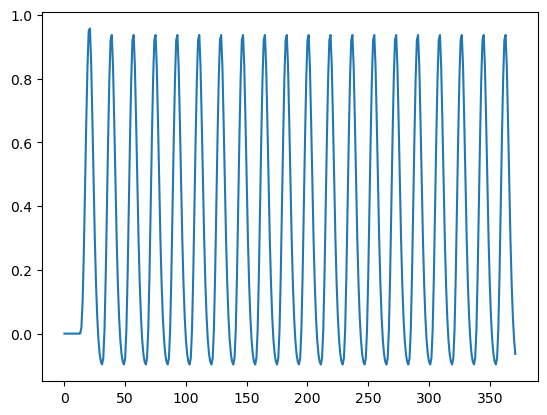

In [26]:
model = design_matrix.iloc[:, 0]
plt.plot(model)

In [32]:
print('TR:', tr)
print('stim duration:', duration_1_stim)
    
print('n_scans', n_scans)
print('onsets', onsets)
print('frame_times', frame_times) 
print('events', events)

TR: 1
stim duration: 6
n_scans 372
onsets [  11   29   47   65   83  101  119  137  155  173  191  209  227  245
  263  281  299  317 3365 3543]
frame_times [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207